In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from datetime import datetime
from datetime import timedelta
import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
import category_encoders as ce
from collections import Counter

# 온라인 스토어 유저 데이터 분석
## 데이터 설명
- `2020-09-24 ~ 2020-12-21`에 걸쳐 일어난 온라인 스토어 유저 데이터
- 컬럼 설명
    - `event_time` : 이벤트 발생 시간
    - `event_type` : 발생한 이벤트 (view, cart, purchase)
    - `product_id` : 제품 id
    - `category_id` : 제품이 속한 카테고리 id
    - `category_code` : 제품이 속한 카테고리 코드
    - `price` : 가격
    - `user_id` : 로그인한 유저 id
    - `user_session` : 유저가 활동한 세션

In [2]:
file_path = "data/events.csv"
df = pd.read_csv(file_path)
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-09-24 11:57:06 UTC,view,1996170,2.140000e+18,electronics.telephone,NaN,31.90,1.520000e+18,LJuJVLEjPT
1,2020-09-24 11:57:26 UTC,view,139905,2.140000e+18,computers.components.cooler,zalman,17.16,1.520000e+18,tdicluNnRY
2,2020-09-24 11:57:27 UTC,view,215454,2.140000e+18,NaN,NaN,9.81,1.520000e+18,4TMArHtXQy
3,2020-09-24 11:57:33 UTC,view,635807,2.140000e+18,computers.peripherals.printer,pantum,113.81,1.520000e+18,aGFYrNgC08
4,2020-09-24 11:57:36 UTC,view,3658723,2.140000e+18,NaN,cameronsino,15.87,1.520000e+18,aa4mmk0kwQ


In [3]:
df.dtypes

event_time        object
event_type        object
product_id         int64
category_id      float64
category_code     object
brand             object
price            float64
user_id          float64
user_session      object
dtype: object

In [4]:
print(np.__version__)

1.26.3


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481999 entries, 0 to 481998
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   event_time     481999 non-null  object 
 1   event_type     481999 non-null  object 
 2   product_id     481999 non-null  int64  
 3   category_id    481999 non-null  float64
 4   category_code  343374 non-null  object 
 5   brand          362130 non-null  object 
 6   price          481999 non-null  float64
 7   user_id        481999 non-null  float64
 8   user_session   481867 non-null  object 
dtypes: float64(3), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
# 결측치 확인
df.isnull().sum()

event_time            0
event_type            0
product_id            0
category_id           0
category_code    138625
brand            119869
price                 0
user_id               0
user_session        132
dtype: int64

In [7]:
df_copy = df.copy()

## event_time 컬럼 나누기

In [8]:
# event_time 컬럼 str -> datetime64로 변경
df_copy["event_time"] = pd.to_datetime(df_copy["event_time"])

# event_time 컬럼 월, 일, 요일, 시로 분리
df_copy["month"] = df_copy["event_time"].dt.month
df_copy["day"] = df_copy["event_time"].dt.day
df_copy["day_name"] = df_copy["event_time"].apply(lambda x : x.day_name())
df_copy["hour"] = df_copy["event_time"].dt.hour

col_order = ['event_time', 'month', 'day', 'day_name', 'hour', 
             'event_type', 'product_id', 'category_id', 'category_code', 
             'brand', 'price', 'user_id', 'user_session']
df_copy = df_copy[col_order]
df_copy.head()

,event_time,month,day,day_name,hour,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-09-24 11:57:06+00:00,9,24,Thursday,11,view,1996170,2.140000e+18,electronics.telephone,NaN,31.90,1.520000e+18,LJuJVLEjPT
1,2020-09-24 11:57:26+00:00,9,24,Thursday,11,view,139905,2.140000e+18,computers.components.cooler,zalman,17.16,1.520000e+18,tdicluNnRY
2,2020-09-24 11:57:27+00:00,9,24,Thursday,11,view,215454,2.140000e+18,NaN,NaN,9.81,1.520000e+18,4TMArHtXQy
3,2020-09-24 11:57:33+00:00,9,24,Thursday,11,view,635807,2.140000e+18,computers.peripherals.printer,pantum,113.81,1.520000e+18,aGFYrNgC08
4,2020-09-24 11:57:36+00:00,9,24,Thursday,11,view,3658723,2.140000e+18,NaN,cameronsino,15.87,1.520000e+18,aa4mmk0kwQ


In [9]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481999 entries, 0 to 481998
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   event_time     481999 non-null  datetime64[ns, UTC]
 1   month          481999 non-null  int32              
 2   day            481999 non-null  int32              
 3   day_name       481999 non-null  object             
 4   hour           481999 non-null  int32              
 5   event_type     481999 non-null  object             
 6   product_id     481999 non-null  int64              
 7   category_id    481999 non-null  float64            
 8   category_code  343374 non-null  object             
 9   brand          362130 non-null  object             
 10  price          481999 non-null  float64            
 11  user_id        481999 non-null  float64            
 12  user_session   481867 non-null  object             
dtypes: datetime64[ns, UTC](1), fl

In [10]:
df_copy["event_type"].value_counts()

event_type
view        435940
cart         26812
purchase     19247
Name: count, dtype: int64

## `.describe` 확인
- `price` 컬럼 평균 약 123인 것에 비해, max 값이 약 64771
    - 이상치가 크다
- `event_type` 컬럼 가장 많은 값 `view`
- `category_code` 컬럼 가장 많은 값 `electronics.telephone`
- `brand` 컬럼 가장 많은 값 `samsung`
- `user_session` 컬럼 `count`는 481867 인 것에 비해 `unique`는 278520
    - `user_session` 여러개 잡힌 사람들 존재
    - 가장 오래 활동한 `user_session : 9HqvxzKlPb`

In [11]:
df_copy.describe()

,month,day,hour,product_id,category_id,price,user_id
count,481999.000000,481999.000000,481999.000000,4.819990e+05,4.819990e+05,481999.000000,4.819990e+05
mean,10.764448,15.572207,12.333378,1.779023e+06,2.140011e+18,123.021122,1.520000e+18
std,0.853664,8.616308,5.392636,1.417504e+06,7.743848e+14,309.405297,6.563847e+05
min,9.000000,1.000000,0.000000,1.020000e+02,2.140000e+18,0.220000,1.520000e+18
25%,10.000000,8.000000,8.000000,6.493080e+05,2.140000e+18,23.570000,1.520000e+18
50%,11.000000,16.000000,12.000000,1.306642e+06,2.140000e+18,56.670000,1.520000e+18
75%,11.000000,23.000000,17.000000,3.605957e+06,2.140000e+18,141.980000,1.520000e+18
max,12.000000,31.000000,23.000000,4.183880e+06,2.230000e+18,64771.060000,1.520000e+18


In [12]:
df_copy.describe(include="object")

,day_name,event_type,category_code,brand,user_session
count,481999,481999,343374,362130,481867
unique,7,3,107,965,278520
top,Monday,view,electronics.telephone,samsung,9HqvxzKlPb
freq,76192,435940,49441,13076,424


## 결측치 처리

### 결측치 설명
- `완전 무작위 결측 (MCAR : Missing Completely At Random)`

    - 변수 상에서 발생한 결측치가 다른 변수들과 아무런 상관이 없는 경우 완전 무작위 결측이라고 부른다.<br>
    대부분의 결측치 처리 패키지가 MCAR을 가정으로 하고 있고 보통 우리가 생각하는 결측치라고 생각하면 된다.   
    예를 들어, 데이터를 깜박하고 입력 안하거나 전산오류로 누락된 경우이다.   
    이러한 결측치는 보통 제거하거나 데이터 셋에서 단순 무작위 표본추출을 통해 완벽한 데이터셋으로 만들 수 있다.<br>

- `무작위 결측 (MAR : Missing At Random)`

    - 결측값이 결측된 변수와는 관련이 없지만 다른변수와는 관련이 있는 경우 무작위 결측이라고 부른다.  
    예를 들어, 여성이 남성보다 체중을 기입하지 않는다. 라고 하면 체중에 결측값이 생기지만,  
    이는 체중 변수와 관련이 있는 것이 아닌 성별 변수와 관련이 있다. 
<br>

- `비 무작위 결측 (MNAR : Missing Not At Random)`

    - 위 두가지 유형이 아닌 경우 MNAR이라고 하고, 결측값이 결측된 변수와 관련이 있는 경우 비 무작위 결측이라고 한다.  
    예를 들어, 서비스에 불만족한 고객들은 만족도 설문에 응답하지 않는다.  
    
- 링크 : https://syj9700.tistory.com/10

### 결측치 구분 예시
- 구분 예시
    * 3번 상태 (MNAR)가 아니라면, 이 결측값 발생이 어느정도 독립적으로 발생하지 않았을까? 라고 생각 가능한 상태가 되고,
    이는 완벽하게 우연히 발생했다면 1번 완전 무작위 결측이 된다 (MCAR)

    * 즉, 결측값의 발생에 뚜렷한 어떤 인과 관계가 숨어있는지 여부로 구분지으면 된다 
        

    * `MCAR(Missing Completely At Random)`
        
        + 특정 column(c_k)의 결측 여부가 완전히 random으로 발생하는 경우,  

        + 즉 c_k가 다른 c_1, c_2, ...와는 관련이 없을 때를 가리킴


    * `MAR(Missing At Random)  `


        + 특정 c_k의 결측 여부가 다른 c_1, c_2, ... 중 몇몇과 관련이 있는 경우  

        + 예를 들면, 소득수준(=c_1)에 따라 학업성취도(=c_k)의 결측 여부가 관련이 있을 경우
        

    * `MNAR(Missing Not At Random, non ignorable)`  

        + 특정 c_k의 결측 여부가 c_k의 값과 관련이 있는 경우  
        
        + 예를 들면, 학업성취도가 낮은 학생들이 학업성취도에 응답하지 않는 경우   
        
        + 우울증이 너무 심한 응답자들이 우울증 문항에 허위 기술을 하거나,  
        정치적, 종교적인 이유로 실제와 전혀 다른 응답하는 경우  
        
        + 위의 예시처럼 설문지 응답에서 중요한 특정 집단이 의도적으로 자신을 감춰버린 상태

    * 링크 : https://gooopy.tistory.com/43  

### 결측치 비율에 따른 결측치 처리 방법 선택
- 결측치 비율 `10% 미만` : 제거 또는 대체
- 결측치 비율 `10% 이상 20% 미만` : 모델 기반 처리
- 결측치 비율 `20% 이상` : 모델 기반 처리
- 출처 : https://cheris8.github.io/data%20analysis/DP-NA-Imputation/

### 결측치 시각화

#### missingno 라이브러리를 통한 시각화

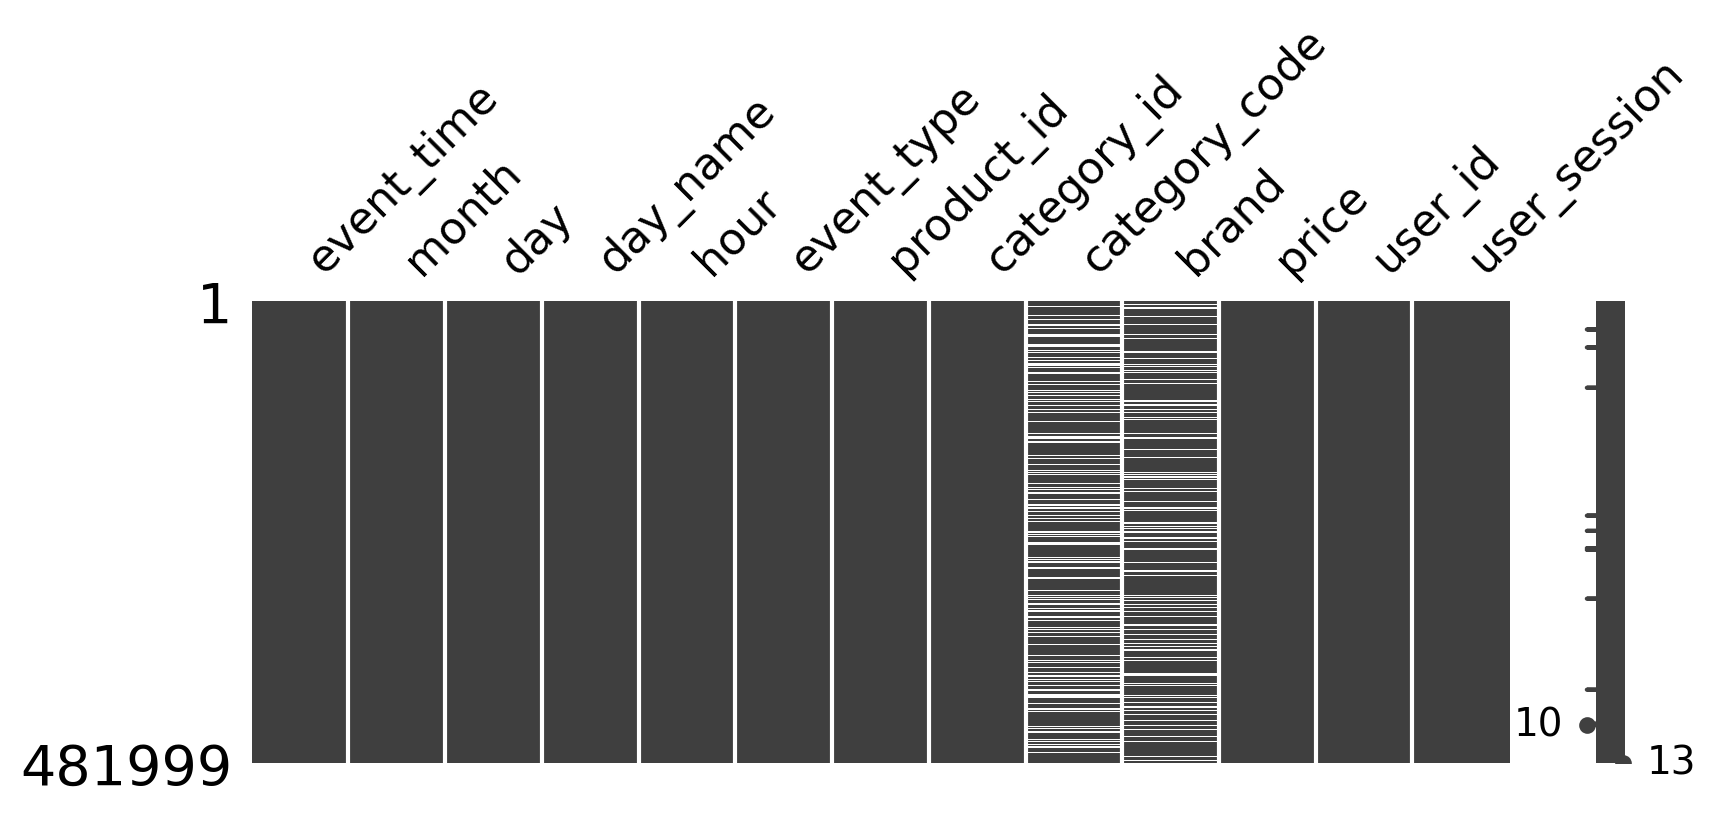

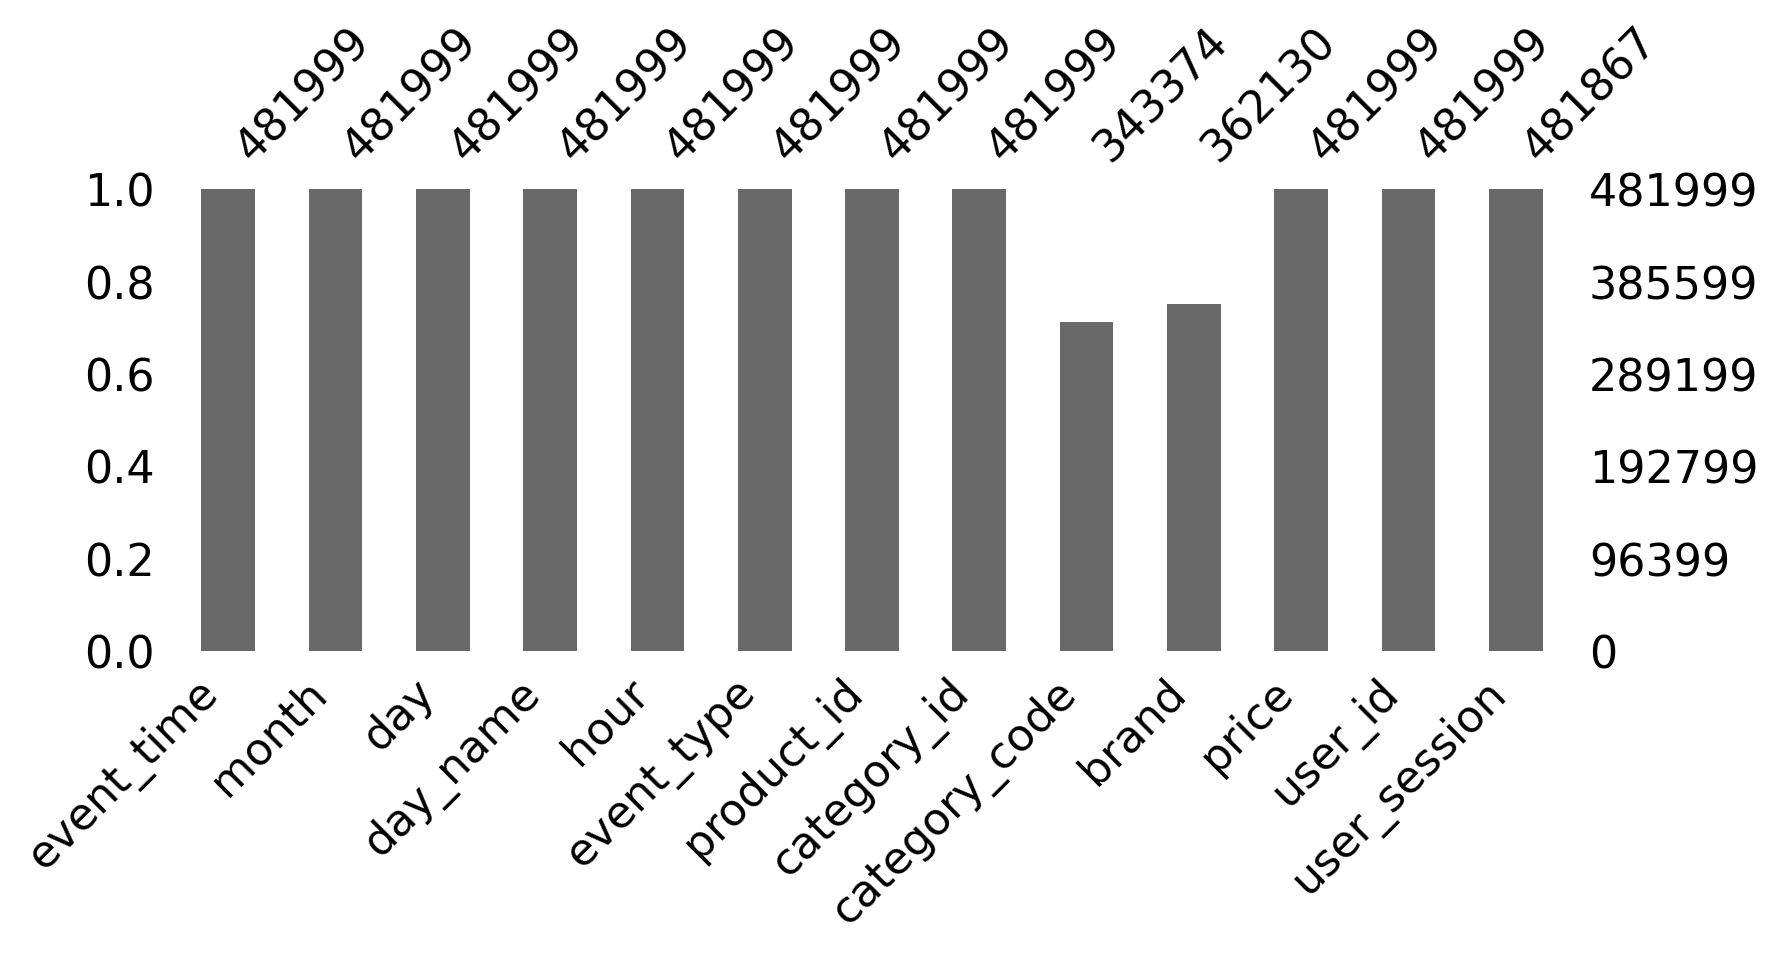

In [13]:
# 결측치 시각화
msno.matrix(df=df_copy, figsize=(9,3))
plt.show()

msno.bar(df_copy, figsize=(9,3))
plt.show()

In [14]:
# 결측치 비율 구함
null_total = df_copy.isnull().sum()
null_count = df_copy.isnull().count()
null_pct = round((null_total/null_count)*100, 1)

# 결측치 개수, 퍼센트 데이터프레임으로 생성
missing = pd.concat([null_total, null_pct], axis=1, keys=["Total", "Percent"])
missing


,Total,Percent
event_time,0,0.0
month,0,0.0
day,0,0.0
day_name,0,0.0
hour,0,0.0
event_type,0,0.0
product_id,0,0.0
category_id,0,0.0
category_code,138625,28.8
brand,119869,24.9


#### barplot 사용하여 결측치 비율 시각화

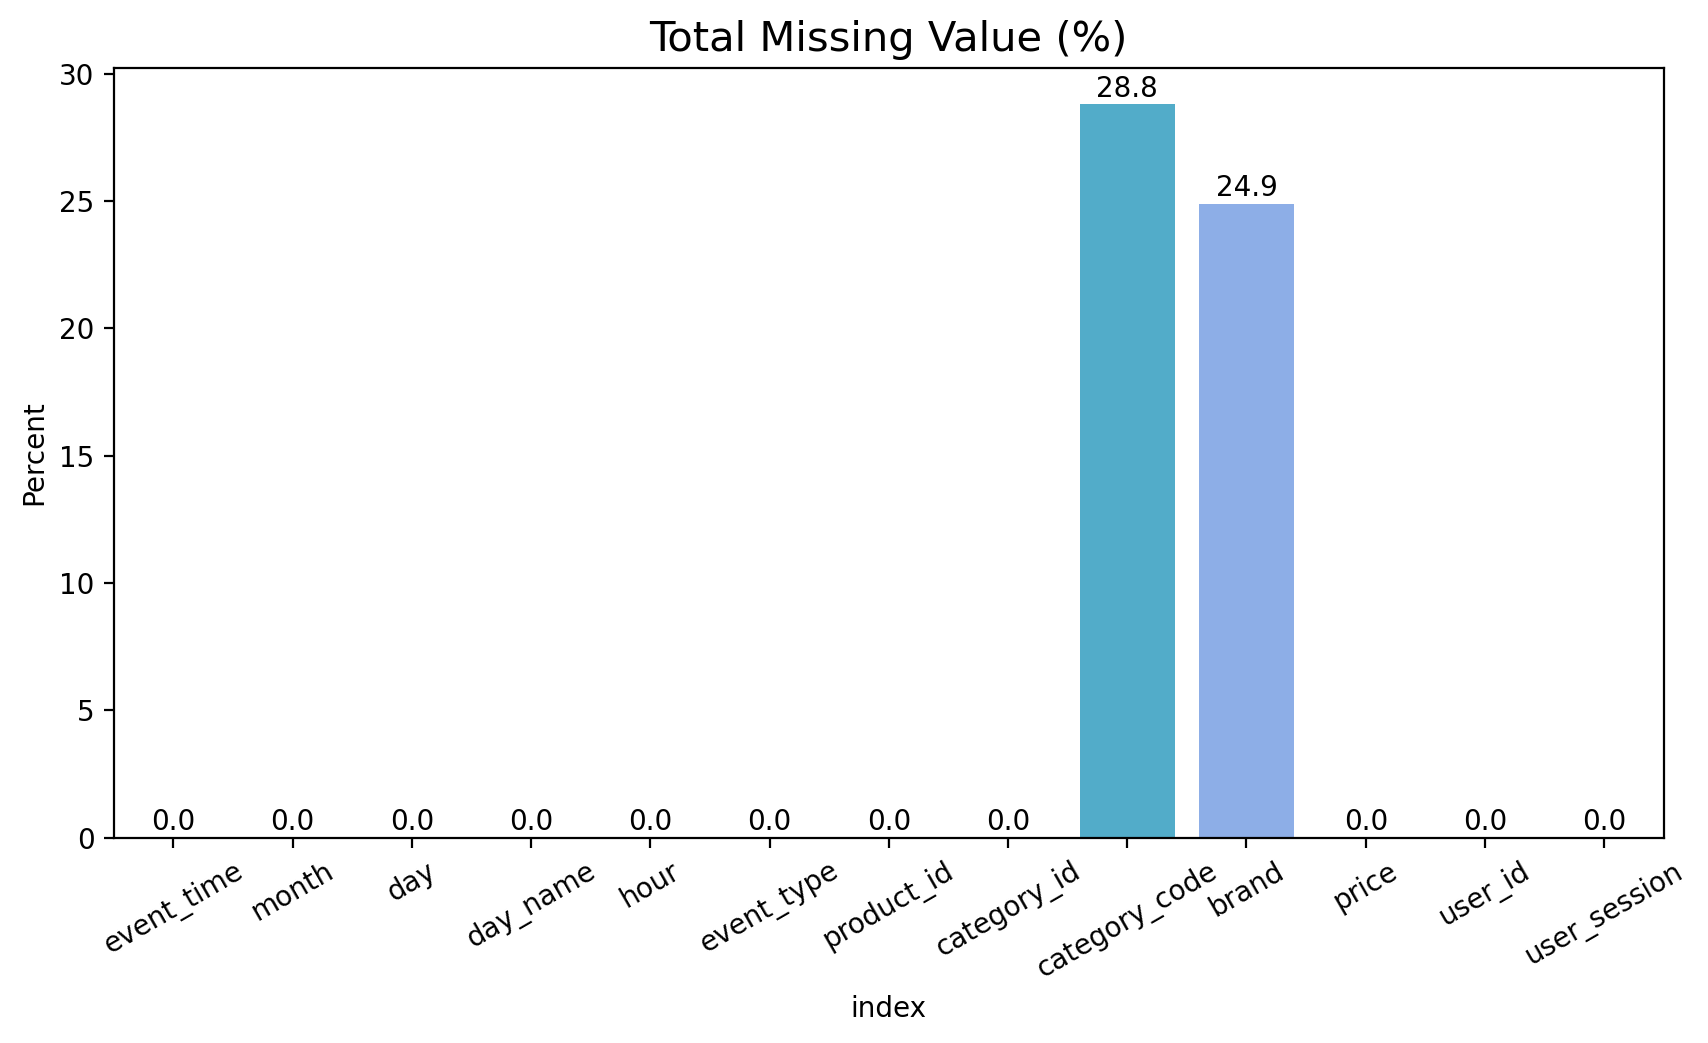

In [15]:
# 결측치 비율 시각화
plt.figure(figsize=(10, 5))
sns_pct = sns.barplot(x="index", y="Percent", data=missing.reset_index())
sns_pct.set_xticklabels(sns_pct.get_xticklabels(), rotation=30)

# bar 그래프 상단에 비율 (%) 표기
for bar in sns_pct.patches:
    height = bar.get_height()                   # .get_height() : y좌표

    plt.text(bar.get_x() + bar.get_width()/2,   # 퍼센트 글자 위치
             height+0.3,                        # 퍼센트 글자 높이
             "%.1f" % height,                   # 퍼센트 소수점 지정
             ha="center")                       # 가운데 정렬

# 시각화 제목 이름, 폰트 크기 지정
sns_pct.set_title("Total Missing Value (%)", fontsize=15)
plt.show()

### 결측치 제거

#### 만약 category_code, brand 동시에 결측치 처리된 값 제거한다면, 결측치 비율 어떨까?

In [16]:
# 전체 값 대비 category_code, brand, 전부 결측인 값들의 비율
null_cond = (df_copy["category_code"].isna()) & (df_copy["brand"].isna())
(df_copy[null_cond].shape[0] / df_copy.shape[0]) * 100

9.8910993591273

In [17]:
# 전체 데이터에서 category_code, brand 둘다 NaN 값인 경우 제거
both_null_cond = (df_copy["category_code"].notna()) | (df_copy["brand"].notna())
print(df_copy.shape)
print(df_copy[both_null_cond].shape)
print("둘 다 결측치인 개수 :", str(df_copy.shape[0]-df_copy[both_null_cond].shape[0]), "개")

(481999, 13)
(434324, 13)
둘 다 결측치인 개수 : 47675 개


In [18]:
df_copy2 = df_copy[both_null_cond]
df_copy2.shape

(434324, 13)

In [19]:
# 결측치 percent 구함
null_total_2 = df_copy2.isnull().sum()
null_count_2 = df_copy2.isnull().count()
percent_2 = round((null_total_2 / null_count_2) * 100, 1)

# # 결측치 개수, 퍼센트 데이터프레임으로 생성
missing_data_2 = pd.concat([null_total_2, percent_2], axis=1, keys=["Total", "Percent"])
missing_data_2

,Total,Percent
event_time,0,0.0
month,0,0.0
day,0,0.0
day_name,0,0.0
hour,0,0.0
event_type,0,0.0
product_id,0,0.0
category_id,0,0.0
category_code,90950,20.9
brand,72194,16.6


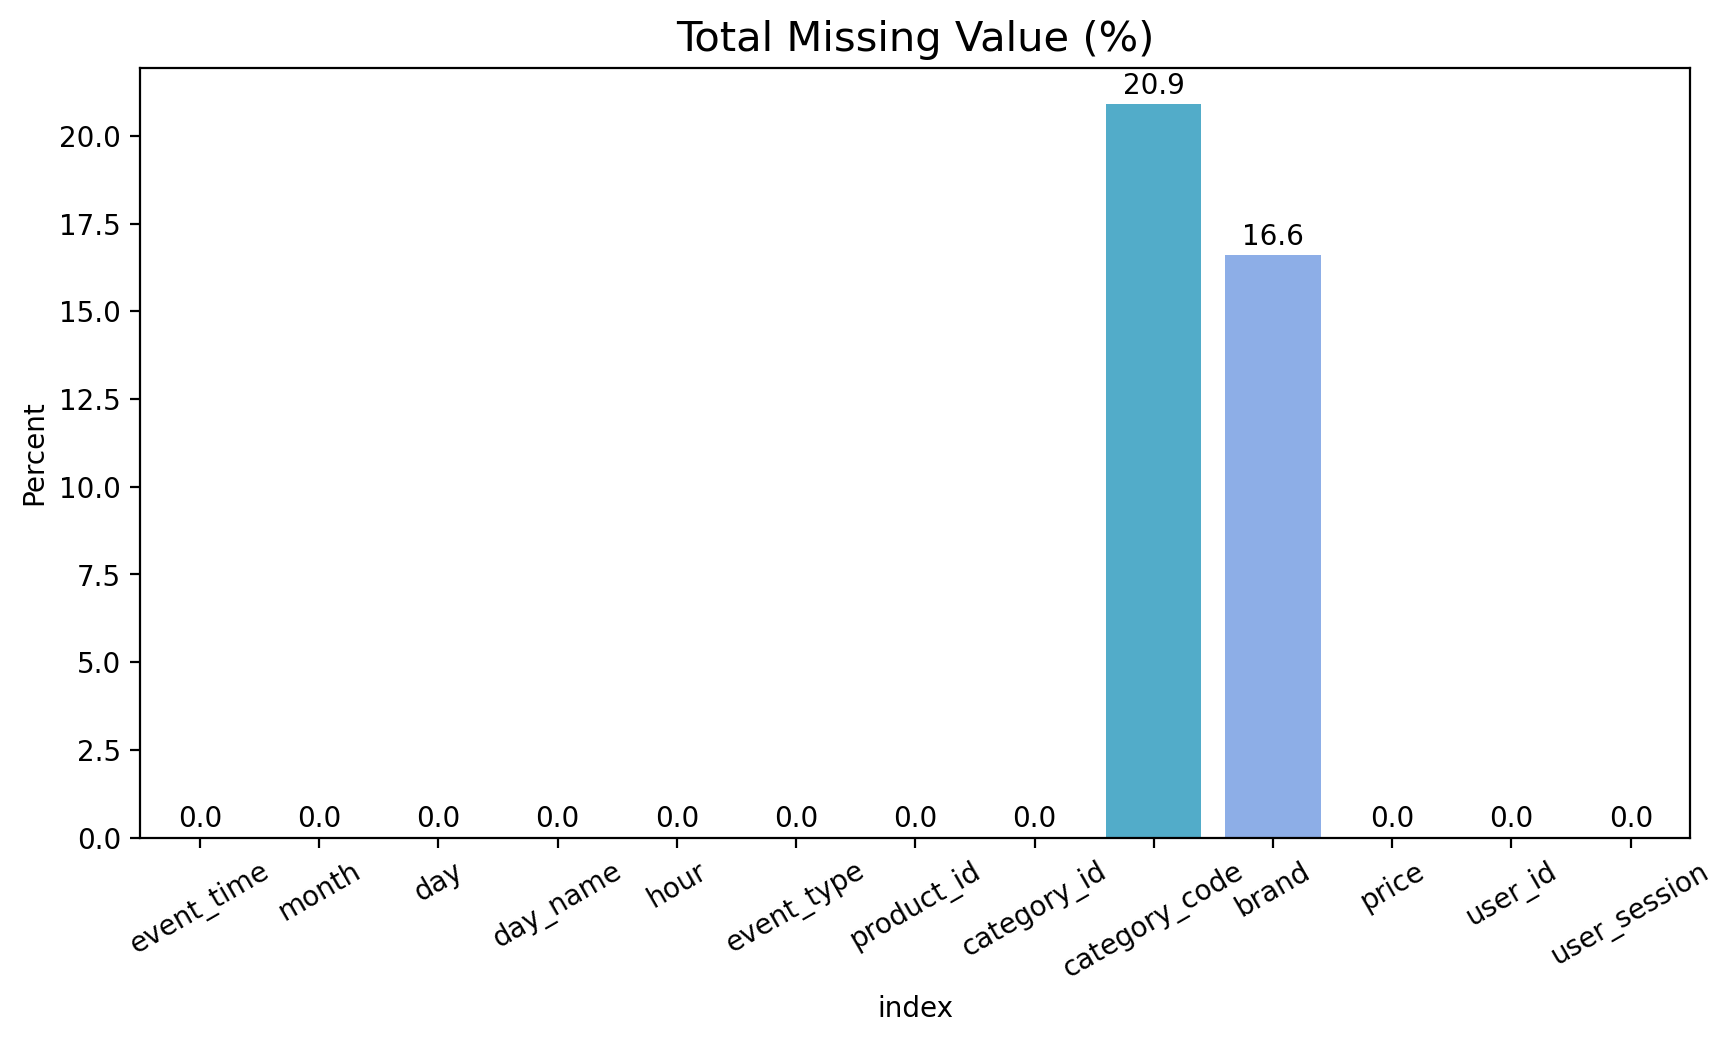

In [20]:
# 결측치 퍼센트 그래프 생성
plt.figure(figsize=(10, 5))
sns_pct_2 = sns.barplot(x="index", y="Percent", data=missing_data_2.reset_index())
sns_pct_2.set_xticklabels(sns_pct_2.get_xticklabels(), rotation=30)

# bar 그래프 상단에 퍼센트 표기
for bar in sns_pct_2.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.3, "%.1f" % height, ha="center")

sns_pct_2.set_title("Total Missing Value (%)", fontsize=15)
plt.show()

In [21]:
# category_code에서의 결측치 확인
# category_id는 있는데, category_code가 결측치인 경우
df_copy2[(df_copy2["category_id"].notnull()) & df_copy2["category_code"].isnull()]

,event_time,month,day,day_name,hour,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
4,2020-09-24 11:57:36+00:00,9,24,Thursday,11,view,3658723,2.140000e+18,NaN,cameronsino,15.87,1.520000e+18,aa4mmk0kwQ
10,2020-09-24 11:58:34+00:00,9,24,Thursday,11,view,811491,2.140000e+18,NaN,ritmix,33.32,1.520000e+18,aFLc6y9kn4
11,2020-09-24 11:58:54+00:00,9,24,Thursday,11,view,811491,2.140000e+18,NaN,ritmix,33.32,1.520000e+18,aFLc6y9kn4
16,2020-09-24 12:00:16+00:00,9,24,Thursday,12,view,3830537,2.140000e+18,NaN,cameronsino,18.10,1.520000e+18,Hsjky2QXGx
18,2020-09-24 12:00:36+00:00,9,24,Thursday,12,view,3830671,2.140000e+18,NaN,pocketbook,24.29,1.520000e+18,brgASCNTJs
...,...,...,...,...,...,...,...,...,...,...,...,...,...
481965,2020-12-21 22:00:30+00:00,12,21,Monday,22,view,4153881,2.140000e+18,NaN,cyberpower,17.02,1.520000e+18,l7DREy2ANF
481971,2020-12-21 22:03:56+00:00,12,21,Monday,22,view,3147,2.140000e+18,NaN,transcend,14.62,1.520000e+18,XdU7IRyzZA
481987,2020-12-21 22:05:43+00:00,12,21,Monday,22,view,3147,2.140000e+18,NaN,transcend,14.62,1.520000e+18,XdU7IRyzZA
481992,2020-12-21 22:09:53+00:00,12,21,Monday,22,view,4013211,2.140000e+18,NaN,kingston,60.02,1.520000e+18,bxGVmW3fWe


In [22]:
# brand가 cameronsino 인 것
df_copy2[df_copy2.brand=="cameronsino"].head()

,event_time,month,day,day_name,hour,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
4,2020-09-24 11:57:36+00:00,9,24,Thursday,11,view,3658723,2.140000e+18,NaN,cameronsino,15.87,1.520000e+18,aa4mmk0kwQ
16,2020-09-24 12:00:16+00:00,9,24,Thursday,12,view,3830537,2.140000e+18,NaN,cameronsino,18.10,1.520000e+18,Hsjky2QXGx
62,2020-09-24 12:09:33+00:00,9,24,Thursday,12,view,1784819,2.140000e+18,NaN,cameronsino,21.43,1.520000e+18,AnBCeDRHyf
79,2020-09-24 12:14:13+00:00,9,24,Thursday,12,view,898068,2.140000e+18,NaN,cameronsino,31.43,1.520000e+18,1bHYvNk4X6
413,2020-09-24 13:30:47+00:00,9,24,Thursday,13,view,3830564,2.140000e+18,NaN,cameronsino,17.30,1.520000e+18,iQWUOqFu43


In [23]:
df_copy2[df_copy2.brand=="cameronsino"]["category_code"].value_counts()

category_code
electronics.audio.acoustic        746
electronics.tablet                185
auto.accessories.gps              130
electronics.audio.headphone        95
electronics.telephone              65
electronics.camera.video           43
computers.notebook                 18
stationery.battery                 18
computers.network.router           15
computers.peripherals.printer       4
appliances.environment.vacuum       2
auto.accessories.videoregister      1
Name: count, dtype: int64

In [24]:
df_copy2[["category_code"]].value_counts()

category_code                   
electronics.telephone               49441
computers.peripherals.printer       27173
computers.components.videocards     26757
stationery.cartrige                 24955
electronics.audio.acoustic          15426
                                    ...  
furniture.bedroom.blanket              17
furniture.kitchen.chair                12
appliances.kitchen.refrigerators        9
auto.accessories.winch                  5
accessories.briefcase                   4
Name: count, Length: 107, dtype: int64

#### KNN? -> 실패

In [25]:
# df_copy2 : df에서 category_code, brand 둘 다 결측치인 경우
# 1. category_code 보간 위해 brand에서 결측치인 것 빼고 진행
# 2. category_code 보간 위해 category_code에서 결측치인 것 빼고 진행

In [26]:
df_copy2.isnull().sum()

event_time           0
month                0
day                  0
day_name             0
hour                 0
event_type           0
product_id           0
category_id          0
category_code    90950
brand            72194
price                0
user_id              0
user_session       121
dtype: int64

In [27]:
target1 = "category_code"
target2 = "brand"

# brand에서 결측치 제거한 데이터프레임 not_null_brand에 선언
not_null_brand = df_copy2[df_copy2.brand.notnull()]
not_null_brand.head()

,event_time,month,day,day_name,hour,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
1,2020-09-24 11:57:26+00:00,9,24,Thursday,11,view,139905,2.140000e+18,computers.components.cooler,zalman,17.16,1.520000e+18,tdicluNnRY
3,2020-09-24 11:57:33+00:00,9,24,Thursday,11,view,635807,2.140000e+18,computers.peripherals.printer,pantum,113.81,1.520000e+18,aGFYrNgC08
4,2020-09-24 11:57:36+00:00,9,24,Thursday,11,view,3658723,2.140000e+18,NaN,cameronsino,15.87,1.520000e+18,aa4mmk0kwQ
5,2020-09-24 11:57:59+00:00,9,24,Thursday,11,view,664325,2.140000e+18,construction.tools.saw,carver,52.33,1.520000e+18,vnkdP81DDW
7,2020-09-24 11:58:24+00:00,9,24,Thursday,11,view,716611,2.140000e+18,computers.network.router,d-link,53.14,1.520000e+18,kVBeYDPcBw


In [26]:
X1 = not_null_brand[["brand", "price"]]
# X1 = not_null_brand[["price"]]

y1 = not_null_brand[target1]

In [27]:
# train/test 데이터셋 분리
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42)

X_train1.shape, X_test1.shape, y_train1.shape, y_test1.shape

((289704, 2), (72426, 2), (289704,), (72426,))

In [28]:
# https://stackoverflow.com/questions/64900801/implementing-knn-imputation-on-categorical-variables-in-an-sklearn-pipeline
    
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
    
prac = pd.DataFrame({'A': ['x', np.NaN, 'z'], 'B': [1, 6, 9], 'C': [2, 1, np.NaN]})
    
# prac = prac.apply(lambda series: pd.Series(
#         LabelEncoder().fit_transform(series[series.notnull()]),
#         index=series[series.notnull()].index
#     ))
    
# imputer = KNNImputer(n_neighbors=1)
# imputer.fit_transform(prac)


In [29]:
prac

,A,B,C
0,x,1,2.0
1,NaN,6,1.0
2,z,9,NaN


In [30]:
prac = prac.apply(lambda series: pd.Series(
        LabelEncoder().fit_transform(series[series.notnull()]),
        index=series[series.notnull()].index
    ))

In [31]:
prac

,A,B,C
0,0.0,0,1.0
1,NaN,1,0.0
2,1.0,2,NaN


In [32]:
imputer = KNNImputer(n_neighbors=1)
imputer.fit_transform(prac)

array([[0., 0., 1.],
       [0., 1., 0.],
       [1., 2., 0.]])

In [33]:
df_copy2.head()

,event_time,month,day,day_name,hour,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-09-24 11:57:06+00:00,9,24,Thursday,11,view,1996170,2.140000e+18,electronics.telephone,NaN,31.90,1.520000e+18,LJuJVLEjPT
1,2020-09-24 11:57:26+00:00,9,24,Thursday,11,view,139905,2.140000e+18,computers.components.cooler,zalman,17.16,1.520000e+18,tdicluNnRY
3,2020-09-24 11:57:33+00:00,9,24,Thursday,11,view,635807,2.140000e+18,computers.peripherals.printer,pantum,113.81,1.520000e+18,aGFYrNgC08
4,2020-09-24 11:57:36+00:00,9,24,Thursday,11,view,3658723,2.140000e+18,NaN,cameronsino,15.87,1.520000e+18,aa4mmk0kwQ
5,2020-09-24 11:57:59+00:00,9,24,Thursday,11,view,664325,2.140000e+18,construction.tools.saw,carver,52.33,1.520000e+18,vnkdP81DDW


##### Target Encoding 진행

In [34]:
# target encoding 시 결측치도 함께 인코딩됨

target_encoder = ce.target_encoder.TargetEncoder(
    cols=["category_code", "brand"],
    handle_missing="return_nan")

target_encoder.fit(df_copy2, df_copy2["price"])

# prac2 = df_copy2.apply(lambda series: pd.Series(
#         target_encoder.fit_transform(series[series.notnull()]),
#         index=series[series.notnull()].index
#     ))

TargetEncoder(cols=['category_code', 'brand'], handle_missing='return_nan')

In [35]:
prac2 = target_encoder.transform(df_copy2)
prac2.head()

,event_time,month,day,day_name,hour,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-09-24 11:57:06+00:00,9,24,Thursday,11,view,1996170,2.140000e+18,73.727905,NaN,31.90,1.520000e+18,LJuJVLEjPT
1,2020-09-24 11:57:26+00:00,9,24,Thursday,11,view,139905,2.140000e+18,26.416823,50.908286,17.16,1.520000e+18,tdicluNnRY
3,2020-09-24 11:57:33+00:00,9,24,Thursday,11,view,635807,2.140000e+18,172.682310,118.310638,113.81,1.520000e+18,aGFYrNgC08
4,2020-09-24 11:57:36+00:00,9,24,Thursday,11,view,3658723,2.140000e+18,NaN,24.259760,15.87,1.520000e+18,aa4mmk0kwQ
5,2020-09-24 11:57:59+00:00,9,24,Thursday,11,view,664325,2.140000e+18,195.221338,63.545341,52.33,1.520000e+18,vnkdP81DDW


In [36]:
df_copy2.shape, prac2.shape

((434324, 13), (434324, 13))

In [68]:
prac2.reset_index(inplace=True)

In [69]:
prac2.isnull().sum()

index                0
event_time           0
month                0
day                  0
day_name             0
hour                 0
event_type           0
product_id           0
category_id          0
category_code    90950
brand            72194
price                0
user_id              0
user_session       121
dtype: int64

In [72]:
df_copy2.reset_index(inplace=True)

In [73]:
null_cat_idx = df_copy2[df_copy2.category_code.isnull()].index.to_list()
null_br_idx = df_copy2[df_copy2.brand.isnull()].index.to_list()

In [74]:
# category_code 결측치 : 그대로 nan으로 남김
prac2.loc[null_cat_idx].head()

,index,event_time,month,day,day_name,hour,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
3,4,2020-09-24 11:57:36+00:00,9,24,Thursday,11,view,3658723,2.140000e+18,NaN,24.259760,15.87,1.520000e+18,aa4mmk0kwQ
8,10,2020-09-24 11:58:34+00:00,9,24,Thursday,11,view,811491,2.140000e+18,NaN,34.400297,33.32,1.520000e+18,aFLc6y9kn4
9,11,2020-09-24 11:58:54+00:00,9,24,Thursday,11,view,811491,2.140000e+18,NaN,34.400297,33.32,1.520000e+18,aFLc6y9kn4
13,16,2020-09-24 12:00:16+00:00,9,24,Thursday,12,view,3830537,2.140000e+18,NaN,24.259760,18.10,1.520000e+18,Hsjky2QXGx
15,18,2020-09-24 12:00:36+00:00,9,24,Thursday,12,view,3830671,2.140000e+18,NaN,183.232666,24.29,1.520000e+18,brgASCNTJs


In [40]:
# brand null 결측치 : 그대로 nan으로 남김
prac2.loc[null_br_idx].head()

,event_time,month,day,day_name,hour,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-09-24 11:57:06+00:00,9,24,Thursday,11,view,1996170,2.140000e+18,73.727905,NaN,31.90,1.520000e+18,LJuJVLEjPT
6,2020-09-24 11:58:23+00:00,9,24,Thursday,11,view,3791349,2.140000e+18,102.884603,NaN,215.41,1.520000e+18,J1t6sIYXiV
22,2020-09-24 12:00:57+00:00,9,24,Thursday,12,view,1642942,2.140000e+18,73.801065,NaN,40.76,1.520000e+18,0r39Gl2v0C
30,2020-09-24 12:01:33+00:00,9,24,Thursday,12,view,888783,2.140000e+18,111.434679,NaN,83.02,1.520000e+18,3jFpdbozOd
38,2020-09-24 12:02:54+00:00,9,24,Thursday,12,view,758525,2.140000e+18,73.727905,NaN,1.57,1.520000e+18,4xoRmrunYk


##### KNN Imputation

In [41]:
knn_imputer = KNNImputer(n_neighbors=5)
cat_code_knn = knn_imputer.fit_transform(prac2[["category_id", "category_code", "price"]])

In [44]:
knn_df = pd.DataFrame(cat_code_knn, columns=["category_id", "category_code", "price"])
knn_df.head()

,category_id,category_code,price
0,2.140000e+18,73.727905,31.90
1,2.140000e+18,26.416823,17.16
2,2.140000e+18,172.682310,113.81
3,2.140000e+18,211.079577,15.87
4,2.140000e+18,195.221338,52.33


In [46]:
knn_df.to_csv("knn_df.csv")

In [41]:
knn_path = "data/knn_df.csv"
df_knn = pd.read_csv(knn_path)
df_knn.head()

,Unnamed: 0,category_id,category_code,price
0,0,2.140000e+18,73.727905,31.90
1,1,2.140000e+18,26.416823,17.16
2,2,2.140000e+18,172.682310,113.81
3,3,2.140000e+18,211.079577,15.87
4,4,2.140000e+18,195.221338,52.33


In [42]:
df_knn.shape

(434324, 4)

In [78]:
# df_knn[df_knn.category_code==195.221338]
df_knn[df_knn.category_code==df_knn.category_code[4]]

,Unnamed: 0,category_id,category_code,price
4,4,2.140000e+18,195.221338,52.33
923,923,2.140000e+18,195.221338,125.71
951,951,2.140000e+18,195.221338,453.98
977,977,2.140000e+18,195.221338,453.98
1156,1156,2.140000e+18,195.221338,244.29
...,...,...,...,...
433238,433238,2.140000e+18,195.221338,128.79
433664,433664,2.140000e+18,195.221338,65.63
433690,433690,2.140000e+18,195.221338,85.56
434293,434293,2.140000e+18,195.221338,163.22


In [82]:
df_knn.loc[null_cat_idx]
# prac2.loc[null_br_idx]


,Unnamed: 0,category_id,category_code,price
3,3,2.140000e+18,211.079577,15.87
8,8,2.140000e+18,211.079577,33.32
9,9,2.140000e+18,211.079577,33.32
13,13,2.140000e+18,211.079577,18.10
15,15,2.140000e+18,211.079577,24.29
...,...,...,...,...
434292,434292,2.140000e+18,211.079577,17.02
434297,434297,2.140000e+18,211.079577,14.62
434313,434313,2.140000e+18,211.079577,14.62
434317,434317,2.140000e+18,211.079577,60.02


In [ ]:
# https://cypision.github.io/useful_fuction/Handling_MissingVal_Using_KNN/
# https://velog.io/@songjeongwoo/%EC%8A%A4%EC%BC%80%EC%9D%BC%EB%A7%81-77xf6ne8
# https://velog.io/@songjeongwoo/series/%EB%8D%B0%EC%9D%B4%ED%84%B0-%EC%A0%84%EC%B2%98%EB%A6%AC
# https://www.kaggle.com/code/mohtashimnawaz/knnimputer-voting-and-stacking-classifiers

In [120]:
# https://stackoverflow.com/questions/36808434/label-encoder-encoding-missing-values
# 추후 참고

# original = df_copy2
# mask = df_copy2.isnull()

# df3 = df_copy2.astype(str).apply(target_encoder.fit_transform)

#### IterativeImputer? -> 실패

In [84]:
# 범주형 칼럼 리스트 cat_columns에 선언
cat_cols = df_copy.select_dtypes(exclude="number").columns.tolist()
cat_cols

['event_time',
 'day_name',
 'event_type',
 'category_code',
 'brand',
 'user_session']

In [85]:
df_encoded = df_copy.copy()

In [86]:
# label encoder 사용해서 event_type 변수 인코딩
# event_type 변수가 target 변수라고 생각함

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label_encoded = df_copy[["event_type"]].apply(le.fit_transform)

label_encoded

,event_type
0,2
1,2
2,2
3,2
4,2
...,...
481994,2
481995,2
481996,2
481997,2


In [87]:
# label encoder로 변경된 target 변수 확인
dict(zip(le.classes_, le.transform(le.classes_)))

{'cart': 0, 'purchase': 1, 'view': 2}

In [88]:
# label encoding한 event_type 컬럼 원래 데이터프레임에 붙임
df_encoded.drop(["event_type"], axis="columns", inplace=True)
df_encoded = df_encoded.join(label_encoded)
df_encoded.head()

,event_time,month,day,day_name,hour,product_id,category_id,category_code,brand,price,user_id,user_session,event_type
0,2020-09-24 11:57:06+00:00,9,24,Thursday,11,1996170,2.140000e+18,electronics.telephone,NaN,31.90,1.520000e+18,LJuJVLEjPT,2
1,2020-09-24 11:57:26+00:00,9,24,Thursday,11,139905,2.140000e+18,computers.components.cooler,zalman,17.16,1.520000e+18,tdicluNnRY,2
2,2020-09-24 11:57:27+00:00,9,24,Thursday,11,215454,2.140000e+18,NaN,NaN,9.81,1.520000e+18,4TMArHtXQy,2
3,2020-09-24 11:57:33+00:00,9,24,Thursday,11,635807,2.140000e+18,computers.peripherals.printer,pantum,113.81,1.520000e+18,aGFYrNgC08,2
4,2020-09-24 11:57:36+00:00,9,24,Thursday,11,3658723,2.140000e+18,NaN,cameronsino,15.87,1.520000e+18,aa4mmk0kwQ,2


In [89]:
# category_encoder 사용하여 frequent encoding
import category_encoders as ce

cols_to_impute = ["category_code", "brand"]

count_enc = ce.CountEncoder()
count_encoded = count_enc.fit_transform(df_encoded[cols_to_impute])

In [90]:
count_encoded.head()

,category_code,brand
0,49441,119869
1,5364,2071
2,138625,119869
3,27173,2272
4,138625,3499


In [91]:
count_encoded.columns = ["cat_code_encoded", "br_encoded"]

# 카테고리 인코딩된 값을 결측치로 매핑

# cat_code_map = {138625 : np.nan}
# br_map = {119869 : np.nan}

count_encoded["cat_code_encoded"] = count_encoded["cat_code_encoded"].map(lambda x : np.nan if x == 138625 else x)
count_encoded["br_encoded"] = count_encoded["br_encoded"].map(lambda x : np.nan if x == 119869 else x)

count_encoded.head()

,cat_code_encoded,br_encoded
0,49441.0,NaN
1,5364.0,2071.0
2,NaN,NaN
3,27173.0,2272.0
4,NaN,3499.0


In [92]:
# count_encoded[count_encoded["cat_code_encoded"]==12045]
count_encoded[count_encoded["br_encoded"]==2071]

,cat_code_encoded,br_encoded
1,5364.0,2071.0
102,5364.0,2071.0
300,NaN,2071.0
306,NaN,2071.0
308,NaN,2071.0
...,...,...
481491,NaN,2071.0
481543,NaN,2071.0
481631,NaN,2071.0
481651,5364.0,2071.0


In [93]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

ii = IterativeImputer()
count_encoded = ii.fit_transform(count_encoded)

In [94]:
count_encoded

array([[49441.        ,  7225.07076662],
       [ 5364.        ,  2071.        ],
       [17300.50827813,  4029.97041206],
       ...,
       [12045.90516927,   582.        ],
       [14399.        , 11900.        ],
       [14201.        ,  5196.        ]])

#### `price` 컬럼 가격에 따른 `category_code`, `brand` 결측치 대체

In [26]:
df_copy2.head()

,event_time,month,day,day_name,hour,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-09-24 11:57:06+00:00,9,24,Thursday,11,view,1996170,2.140000e+18,electronics.telephone,NaN,31.90,1.520000e+18,LJuJVLEjPT
1,2020-09-24 11:57:26+00:00,9,24,Thursday,11,view,139905,2.140000e+18,computers.components.cooler,zalman,17.16,1.520000e+18,tdicluNnRY
3,2020-09-24 11:57:33+00:00,9,24,Thursday,11,view,635807,2.140000e+18,computers.peripherals.printer,pantum,113.81,1.520000e+18,aGFYrNgC08
4,2020-09-24 11:57:36+00:00,9,24,Thursday,11,view,3658723,2.140000e+18,NaN,cameronsino,15.87,1.520000e+18,aa4mmk0kwQ
5,2020-09-24 11:57:59+00:00,9,24,Thursday,11,view,664325,2.140000e+18,construction.tools.saw,carver,52.33,1.520000e+18,vnkdP81DDW


In [27]:
# category_code 컬럼 value_counts -> telephone이 제일 많음
df_copy2.category_code.value_counts(normalize=True)[:10]

category_code
electronics.telephone               0.143986
computers.peripherals.printer       0.079135
computers.components.videocards     0.077924
stationery.cartrige                 0.072676
electronics.audio.acoustic          0.044925
computers.notebook                  0.044063
computers.components.cpu            0.041934
computers.components.motherboard    0.041357
electronics.video.tv                0.035294
electronics.tablet                  0.033637
Name: proportion, dtype: float64

##### price 열 가격별 정렬
- 가장 높은 가격 TOP 5
- 가장 빈번한 가격 TOP 5

In [28]:
# price열 가격 높은 순으로 몇 퍼센트 차지하는지 확인
df_copy2["price"].value_counts(normalize=True).sort_index(ascending=False)

price
64771.06    0.000007
42590.13    0.000007
27775.87    0.000009
26985.35    0.000005
26909.62    0.000002
              ...   
2.43        0.000009
2.11        0.000005
1.57        0.004190
0.90        0.000150
0.37        0.000239
Name: proportion, Length: 11164, dtype: float64

In [29]:
# price 컬럼 가장 높은 가격 TOP 5 차지하는 것 뭔지 확인 
# 64771.06    -> monitor (lg)
# 42590.13    -> tv (samsung)
# 27775.87    -> tv (samsung)
# 26985.35    -> NaN (dell)
# 26909.62    -> printer (NaN)
df_copy2[df_copy2.price == 64771.06]

,event_time,month,day,day_name,hour,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
51272,2020-10-06 06:54:04+00:00,10,6,Tuesday,6,view,4170916,2.140000e+18,computers.peripherals.monitor,lg,64771.06,1.520000e+18,pfaAniPp5L
86316,2020-10-14 06:26:41+00:00,10,14,Wednesday,6,view,4170916,2.140000e+18,computers.peripherals.monitor,lg,64771.06,1.520000e+18,M91MkaVScv
418716,2020-12-09 18:31:21+00:00,12,9,Wednesday,18,view,4170916,2.140000e+18,computers.peripherals.monitor,lg,64771.06,1.520000e+18,3cyaesEFAP


In [30]:
df_copy2[df_copy2.price == 42590.13]

,event_time,month,day,day_name,hour,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
298701,2020-11-17 11:13:29+00:00,11,17,Tuesday,11,view,4078837,2.140000e+18,electronics.video.tv,samsung,42590.13,1.520000e+18,HXN3XBovmM
324573,2020-11-20 19:28:42+00:00,11,20,Friday,19,view,4078837,2.140000e+18,electronics.video.tv,samsung,42590.13,1.520000e+18,JkHJ3MLtXV
395298,2020-12-04 13:58:20+00:00,12,4,Friday,13,view,4078837,2.140000e+18,electronics.video.tv,samsung,42590.13,1.520000e+18,5IhxKg1wPN


In [31]:
df_copy2[df_copy2.price == 27775.87]

,event_time,month,day,day_name,hour,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
13638,2020-09-27 21:29:46+00:00,9,27,Sunday,21,view,4078834,2.140000e+18,electronics.video.tv,samsung,27775.87,1.520000e+18,NGhlgCsxv1
20028,2020-09-29 08:54:53+00:00,9,29,Tuesday,8,view,4078834,2.140000e+18,electronics.video.tv,samsung,27775.87,1.520000e+18,NGhlgCsxv1
329065,2020-11-21 15:07:35+00:00,11,21,Saturday,15,view,4078834,2.140000e+18,electronics.video.tv,samsung,27775.87,1.520000e+18,I6pge0lwoQ
447859,2020-12-15 14:55:49+00:00,12,15,Tuesday,14,view,4078834,2.140000e+18,electronics.video.tv,samsung,27775.87,1.520000e+18,NYUVyRmTda


In [32]:
df_copy2[df_copy2.price == 26985.35]

,event_time,month,day,day_name,hour,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
262860,2020-11-12 04:18:19+00:00,11,12,Thursday,4,view,3830190,2.140000e+18,NaN,dell,26985.35,1.520000e+18,7P8fKCaVcF
269401,2020-11-13 04:10:46+00:00,11,13,Friday,4,view,3830190,2.140000e+18,NaN,dell,26985.35,1.520000e+18,7P8fKCaVcF


In [33]:
df_copy2[df_copy2.price == 26909.62]

,event_time,month,day,day_name,hour,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
63739,2020-10-08 19:05:25+00:00,10,8,Thursday,19,view,4101181,2.140000e+18,computers.peripherals.printer,NaN,26909.62,1.520000e+18,Ij8naU5MnW


In [34]:
# price 컬럼 가장 빈번하게 나오는 가격과 그 비율 확인
df_copy2.price.value_counts(normalize=True)

price
204.29     0.010775
43.11      0.008388
32.22      0.007642
64.48      0.005726
397.48     0.004531
             ...   
472.38     0.000002
1209.43    0.000002
232.22     0.000002
50.29      0.000002
246.38     0.000002
Name: proportion, Length: 11164, dtype: float64

In [35]:
# price 컬럼 빈번하게 나오는 가격 TOP 5 차지하는 것 뭔지 확인 
# 204.29    -> CPU (amd)
# 43.11     -> brand 다양함 (결측치도 존재)
# 32.22     -> brand 다양함 (결측치도 존재)
# 64.48      -> brand 다양함
# 397.48     -> brand 다양함 (결측치도 존재)

df_copy2[df_copy2.price == 204.29][["category_code", "brand", "price"]].value_counts(dropna=False)

category_code             brand  price 
computers.components.cpu  amd    204.29    4680
Name: count, dtype: int64

In [36]:
df_copy2[df_copy2.price == 43.11][["category_code", "brand", "price"]].value_counts(dropna=False)

category_code                      brand     price
stationery.cartrige                canon     43.11    3371
computers.peripherals.camera       logitech  43.11     246
appliances.kitchen.meat_grinder    NaN       43.11      13
appliances.environment.air_heater  timberk   43.11       9
NaN                                scarlett  43.11       2
                                   cactus    43.11       1
                                   hama      43.11       1
Name: count, dtype: int64

In [37]:
df_copy2[df_copy2.price == 32.22][["category_code", "brand", "price"]].value_counts(dropna=False)

category_code                   brand         price
electronics.telephone           NaN           32.22    3146
computers.desktop               multitronics  32.22      61
medicine.tools.tonometer        NaN           32.22      45
auto.accessories.videoregister  NaN           32.22      21
NaN                             huawei        32.22      10
electronics.audio.acoustic      edge          32.22       8
NaN                             sinbo         32.22       5
computers.notebook              mobilepc      32.22       5
electronics.telephone           nobby         32.22       4
NaN                             pitatel       32.22       3
                                romoss        32.22       3
electronics.audio.headphone     remax         32.22       2
NaN                             cameronsino   32.22       2
appliances.kitchen.kettle       first         32.22       1
NaN                             greenconnect  32.22       1
electronics.audio.acoustic      alpine        32

In [38]:
df_copy2[df_copy2.price == 64.48][["category_code", "brand", "price"]].value_counts(dropna=False)

category_code                     brand      price
computers.components.motherboard  asus       64.48    2359
computers.components.videocards   asus       64.48      89
computers.components.hdd          transcend  64.48      30
computers.components.cpu          intel      64.48       9
Name: count, dtype: int64

In [39]:
df_copy2[df_copy2.price == 397.48][["category_code", "brand", "price"]].value_counts(dropna=False)

category_code                    brand  price 
computers.components.videocards  NaN    397.48    1961
                                 palit  397.48       7
Name: count, dtype: int64

##### 결측치 처리 기준
- `category_id` 컬럼은 특정 id에 분포가 쏠려있다
    - `2.140000e+18`이 481781 개 (총 데이터 개수 481999의 약 99.9%)
- 하나의 `product_id`에 `category_code`, `brand` 결측치와 정상적으로 채워진 값 동시에 존재하지 않는다
    - 그래서 `product_id`를 기준으로 삼지 않음
- `price` 컬럼을 기준으로 `category_code`, `brand` 결측치 채움

In [40]:
# 하나의 product_id에서 brand 정상적인 값, 결측치 모두 존재하는지 확인 -> 없다
len(df_copy2.groupby(["product_id", "brand"], dropna=False)) - sum(df_copy2.groupby(["product_id", "brand"], dropna=False)["product_id"].nunique())

0

In [41]:
# 하나의 product_id에서 category_code 정상적인 값, 결측치 모두 존재하는지 확인 -> 없다
len(df_copy2.groupby(["product_id", "category_code"], dropna=False)) - sum(df_copy2.groupby(["product_id", "category_code"], dropna=False)["product_id"].nunique())

0

c:\Users\aryij\anaconda3\envs\multi_cat\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


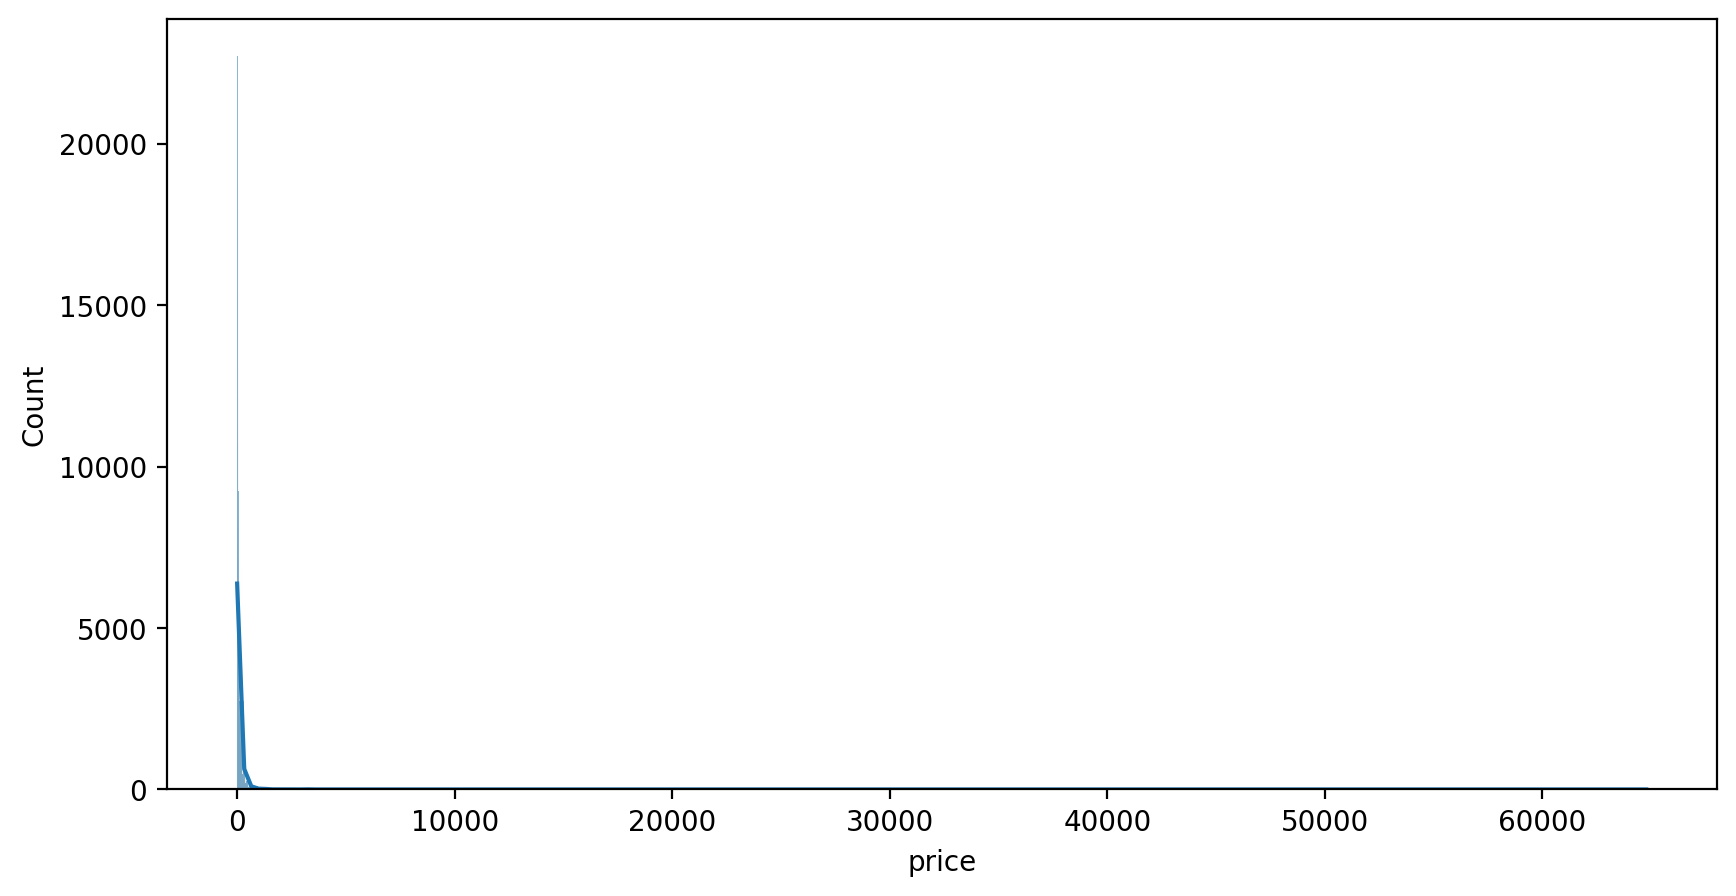

In [42]:
# price 컬럼의 분포 확인 -> 이상치 때문에 왼쪽으로 기울어져 있다
plt.figure(figsize = (10, 5))
sns.histplot(data=df_copy2, x="price", kde=True)
plt.show()

# 분포가 치우쳐져 있기 때문에 category_code, brand의 최빈값 사용
# 수치형 데이터가 아니기 때문에 중앙값 사용 불가

In [43]:
# price 컬럼의 value 종류 별로 category_code 최빈값 검색
# grp_pr_cat = df_copy2.groupby(["price"], dropna=False)["category_code"].agg([pd.Series.mode])
# grp_pr_cat

In [44]:
# price 컬럼의 value 종류 별로 category_code 최빈값 검색
grp_pr_cat = df_copy2.groupby(["price"], dropna=False)["category_code"].agg([lambda x: x.mode().max()])
grp_pr_cat

,<lambda>
price,
0.37,NaN
0.90,electronics.audio.headphone
1.57,electronics.telephone
2.11,kids.toys
2.43,electronics.telephone
...,...
26909.62,computers.peripherals.printer
26985.35,NaN
27775.87,electronics.video.tv


In [45]:
# price 컬럼의 value 종류 별로 brand 최빈값 검색
grp_pr_br = df_copy2.groupby(["price"], dropna=False)["brand"].agg([lambda x: x.mode().max()])
grp_pr_br

,<lambda>
price,
0.37,buro
0.90,defender
1.57,digma
2.11,NaN
2.43,nokia
...,...
26909.62,NaN
26985.35,dell
27775.87,samsung


In [46]:
grp_pr_cat_br = pd.merge(grp_pr_cat, grp_pr_br, on="price")
grp_pr_cat_br.reset_index(inplace=True)

In [47]:
grp_pr_cat_br.columns = ["price", "cat_mode", "br_mode"]
grp_pr_cat_br.head()

,price,cat_mode,br_mode
0,0.37,NaN,buro
1,0.90,electronics.audio.headphone,defender
2,1.57,electronics.telephone,digma
3,2.11,kids.toys,NaN
4,2.43,electronics.telephone,nokia


##### 결측치 처리 시행
- `price` 별로 `category_code`, `brand` 최빈값 구한 데이터프레임 `grp_pr_cat_br` 사용
- `grp_pr_cat_br`을 `df_copy3`과 `price` 기준으로 `merge`
    - `df_copy3`에서 `category_code`, `brand` 결측치를 `grp_pr_cat_br`의 `cat_mode`, `br_mode` 컬럼에서 채운다
- 그래도 결측치로 처리되는 것은 `drop`

In [48]:
df_copy3 = df_copy2.copy()
df_copy3.reset_index(inplace=True, drop=True)

In [49]:
df_copy3.head()

,event_time,month,day,day_name,hour,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-09-24 11:57:06+00:00,9,24,Thursday,11,view,1996170,2.140000e+18,electronics.telephone,NaN,31.90,1.520000e+18,LJuJVLEjPT
1,2020-09-24 11:57:26+00:00,9,24,Thursday,11,view,139905,2.140000e+18,computers.components.cooler,zalman,17.16,1.520000e+18,tdicluNnRY
2,2020-09-24 11:57:33+00:00,9,24,Thursday,11,view,635807,2.140000e+18,computers.peripherals.printer,pantum,113.81,1.520000e+18,aGFYrNgC08
3,2020-09-24 11:57:36+00:00,9,24,Thursday,11,view,3658723,2.140000e+18,NaN,cameronsino,15.87,1.520000e+18,aa4mmk0kwQ
4,2020-09-24 11:57:59+00:00,9,24,Thursday,11,view,664325,2.140000e+18,construction.tools.saw,carver,52.33,1.520000e+18,vnkdP81DDW


In [50]:
df_copy3.shape

(434324, 13)

In [51]:
# df_copy3과 category_code, brand 최빈값 구한 grp_pr_cat_br merge
df_merged = pd.merge(df_copy3, grp_pr_cat_br, on="price")
df_merged

,event_time,month,day,day_name,hour,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,cat_mode,br_mode
0,2020-09-24 11:57:06+00:00,9,24,Thursday,11,view,1996170,2.140000e+18,electronics.telephone,NaN,31.90,1.520000e+18,LJuJVLEjPT,electronics.telephone,pitatel
1,2020-09-24 13:58:51+00:00,9,24,Thursday,13,view,790590,2.140000e+18,computers.notebook,NaN,31.90,1.520000e+18,IBu02xVrhQ,electronics.telephone,pitatel
2,2020-09-24 14:00:24+00:00,9,24,Thursday,14,view,790590,2.140000e+18,computers.notebook,NaN,31.90,1.520000e+18,l68Br3I0Tl,electronics.telephone,pitatel
3,2020-09-25 08:36:13+00:00,9,25,Friday,8,view,751693,2.140000e+18,computers.notebook,pitatel,31.90,1.520000e+18,6fTFbeiEqq,electronics.telephone,pitatel
4,2020-09-30 16:16:16+00:00,9,30,Wednesday,16,view,751693,2.140000e+18,computers.notebook,pitatel,31.90,1.520000e+18,poHN5cBucr,electronics.telephone,pitatel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434319,2020-12-21 16:36:39+00:00,12,21,Monday,16,view,217322,2.140000e+18,stationery.cartrige,NaN,41.05,1.520000e+18,TGzQ20wCX3,stationery.cartrige,NaN
434320,2020-12-21 16:38:13+00:00,12,21,Monday,16,view,217313,2.140000e+18,stationery.cartrige,NaN,59.94,1.520000e+18,TGzQ20wCX3,stationery.cartrige,NaN
434321,2020-12-21 18:00:57+00:00,12,21,Monday,18,view,589658,2.140000e+18,stationery.cartrige,NaN,217.24,1.520000e+18,zLPUsoYbIF,stationery.cartrige,NaN
434322,2020-12-21 19:38:06+00:00,12,21,Monday,19,view,586674,2.140000e+18,stationery.cartrige,hp,82.21,1.520000e+18,pOWsvdaIdO,stationery.cartrige,hp


In [52]:
# category_code 결측치는 cat_mode 컬럼에서 가져와서 채운다
df_merged.loc[df_merged.category_code.isnull(), "category_code"] = df_merged.loc[df_merged.category_code.isnull(), "cat_mode"]

In [53]:
# brand 결측치는 br_mode 컬럼에서 가져와서 채운다
df_merged.loc[df_merged.brand.isnull(), "brand"] = df_merged.loc[df_merged.brand.isnull(), "br_mode"]

In [55]:
df_merged.isnull().sum()

event_time           0
month                0
day                  0
day_name             0
hour                 0
event_type           0
product_id           0
category_id          0
category_code    20801
brand             5501
price                0
user_id              0
user_session       121
cat_mode         20801
br_mode           5501
dtype: int64

In [56]:
# 결측치 percent 구함
null_total_3 = df_merged.isnull().sum()
null_count_3 = df_merged.isnull().count()
percent_3 = round((null_total_3 / null_count_3) * 100, 1)

# # 결측치 개수, 퍼센트 데이터프레임으로 생성
missing_data_3 = pd.concat([null_total_3, percent_3], axis=1, keys=["Total", "Percent"])
missing_data_3

,Total,Percent
event_time,0,0.0
month,0,0.0
day,0,0.0
day_name,0,0.0
hour,0,0.0
event_type,0,0.0
product_id,0,0.0
category_id,0,0.0
category_code,20801,4.8
brand,5501,1.3


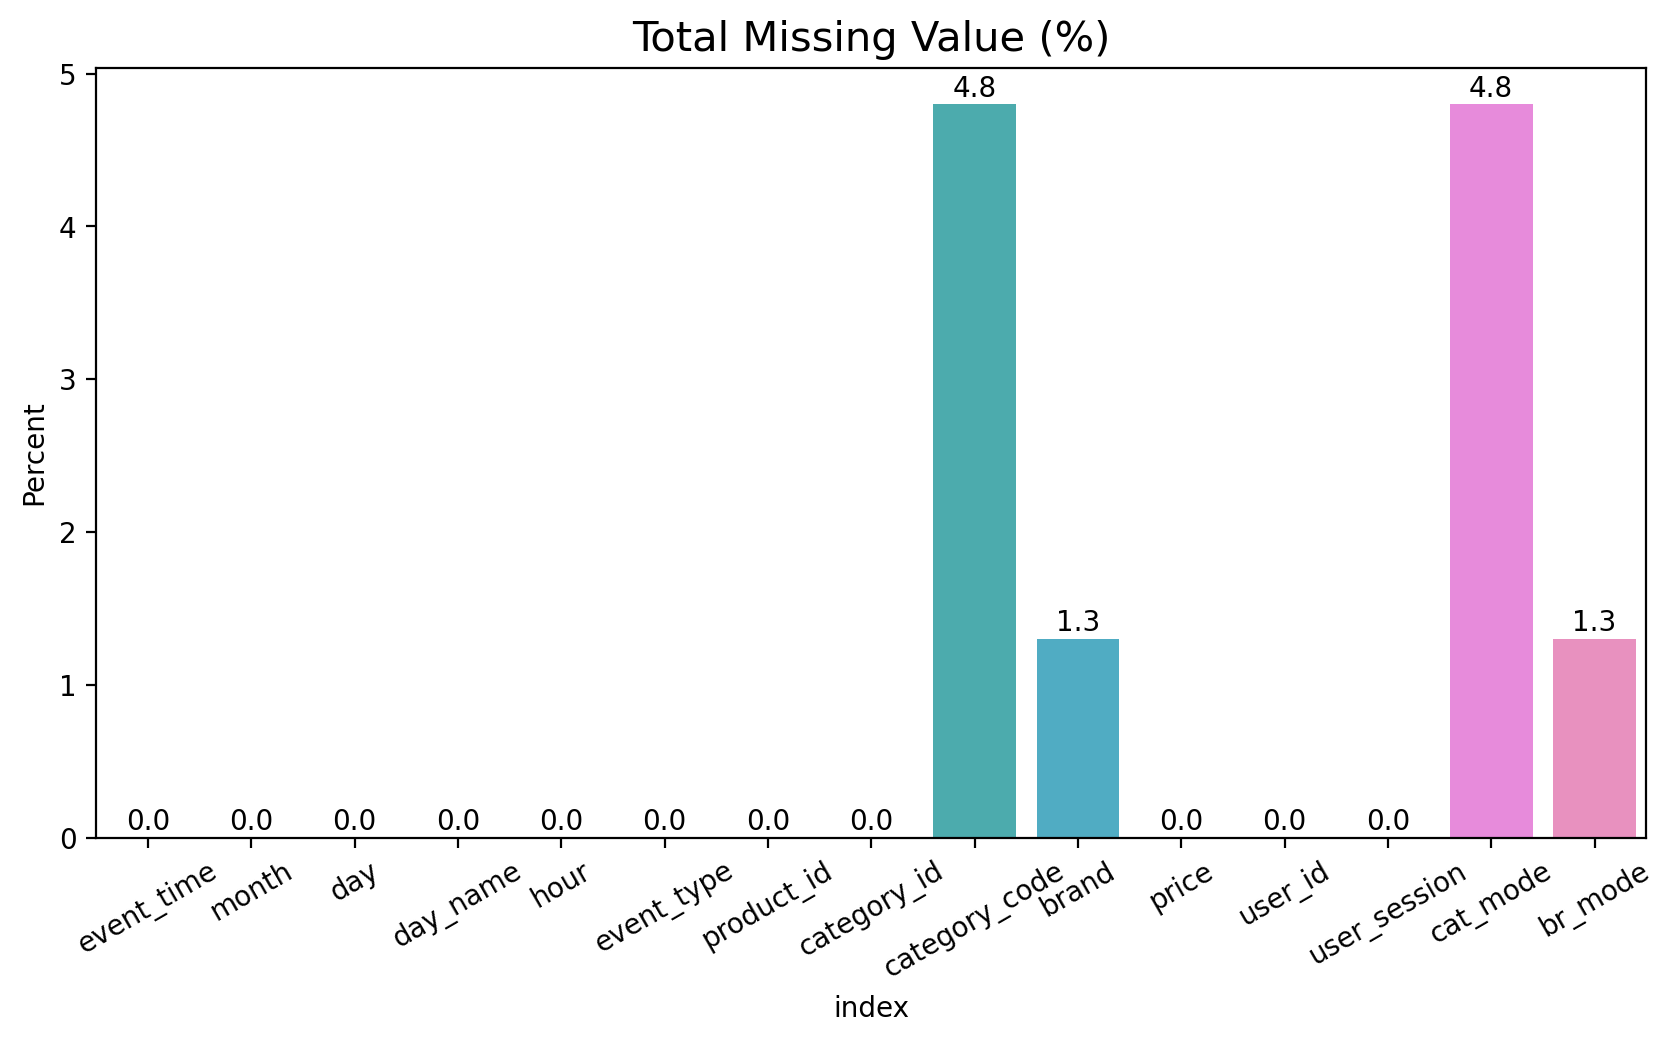

In [57]:
# 결측치 퍼센트 그래프 생성
plt.figure(figsize=(10, 5))
sns_pct_3 = sns.barplot(x="index", y="Percent", data=missing_data_3.reset_index())
sns_pct_3.set_xticklabels(sns_pct_3.get_xticklabels(), rotation=30)

# bar 그래프 상단에 퍼센트 표기
for bar in sns_pct_3.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.05, "%.1f" % height, ha="center")

sns_pct_3.set_title("Total Missing Value (%)", fontsize=15)
plt.show()

In [58]:
# df_merged 결측치 확인
df_merged.isnull().sum()

event_time           0
month                0
day                  0
day_name             0
hour                 0
event_type           0
product_id           0
category_id          0
category_code    20801
brand             5501
price                0
user_id              0
user_session       121
cat_mode         20801
br_mode           5501
dtype: int64

In [59]:
# 그래도 결측치로 남아있는 것들 drop
# 약 26411개 삭제
df_dropped = df_merged.dropna()
print(df_merged.shape, df_dropped.shape)
print(df_merged.shape[0] - df_dropped.shape[0], "개 행 삭제", round((df_merged.shape[0] - df_dropped.shape[0])/df_merged.shape[0], 2),"% 제거")

(434324, 15) (407913, 15)
26411 개 행 삭제 0.06 % 제거


In [60]:
df_dropped.reset_index(inplace=True, drop=True)
df_dropped

,event_time,month,day,day_name,hour,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,cat_mode,br_mode
0,2020-09-24 11:57:06+00:00,9,24,Thursday,11,view,1996170,2.140000e+18,electronics.telephone,pitatel,31.90,1.520000e+18,LJuJVLEjPT,electronics.telephone,pitatel
1,2020-09-24 13:58:51+00:00,9,24,Thursday,13,view,790590,2.140000e+18,computers.notebook,pitatel,31.90,1.520000e+18,IBu02xVrhQ,electronics.telephone,pitatel
2,2020-09-24 14:00:24+00:00,9,24,Thursday,14,view,790590,2.140000e+18,computers.notebook,pitatel,31.90,1.520000e+18,l68Br3I0Tl,electronics.telephone,pitatel
3,2020-09-25 08:36:13+00:00,9,25,Friday,8,view,751693,2.140000e+18,computers.notebook,pitatel,31.90,1.520000e+18,6fTFbeiEqq,electronics.telephone,pitatel
4,2020-09-30 16:16:16+00:00,9,30,Wednesday,16,view,751693,2.140000e+18,computers.notebook,pitatel,31.90,1.520000e+18,poHN5cBucr,electronics.telephone,pitatel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407908,2020-12-21 13:25:50+00:00,12,21,Monday,13,view,695503,2.140000e+18,computers.network.router,d-link,682.56,1.520000e+18,TU3HJxTZz4,computers.network.router,d-link
407909,2020-12-21 13:46:48+00:00,12,21,Monday,13,view,1012989,2.140000e+18,electronics.video.tv,hyundai,126.03,1.520000e+18,5ZMDadMXkO,electronics.video.tv,hyundai
407910,2020-12-21 15:31:58+00:00,12,21,Monday,15,view,3605780,2.140000e+18,accessories.bag,thermos,8.81,1.520000e+18,PYjvdxNImA,accessories.bag,thermos
407911,2020-12-21 16:11:25+00:00,12,21,Monday,16,view,1652970,2.140000e+18,electronics.video.tv,samsung,297.37,1.520000e+18,CICmjyK027,electronics.video.tv,samsung


In [61]:
# cat_mode, br_mode 컬럼 삭제
df_dropped.drop(["cat_mode", "br_mode"], axis=1, inplace=True)

C:\Users\aryij\AppData\Local\Temp\ipykernel_34212\1906580749.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dropped.drop(["cat_mode", "br_mode"], axis=1, inplace=True)


In [62]:
df_preprocessed = df_dropped.copy()

In [63]:
# category_code 대분류, 중분류, 소분류로 각각 나눔
# cat_code_1, cat_code_2, cat_code_3으로 선언
df_preprocessed["cat_code_1"] = df_dropped["category_code"].str.split(".").str[0]
df_preprocessed["cat_code_2"] = df_dropped["category_code"].str.split(".").str[1]
df_preprocessed["cat_code_3"] = df_dropped["category_code"].str.split(".").str[2]

In [64]:
# 소분류가 따로 없어 NaN으로 잡히는 것들 None으로 변경
df_preprocessed["cat_code_3"].fillna("no_cat", inplace=True)

In [65]:
df_preprocessed

,event_time,month,day,day_name,hour,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,cat_code_1,cat_code_2,cat_code_3
0,2020-09-24 11:57:06+00:00,9,24,Thursday,11,view,1996170,2.140000e+18,electronics.telephone,pitatel,31.90,1.520000e+18,LJuJVLEjPT,electronics,telephone,no_cat
1,2020-09-24 13:58:51+00:00,9,24,Thursday,13,view,790590,2.140000e+18,computers.notebook,pitatel,31.90,1.520000e+18,IBu02xVrhQ,computers,notebook,no_cat
2,2020-09-24 14:00:24+00:00,9,24,Thursday,14,view,790590,2.140000e+18,computers.notebook,pitatel,31.90,1.520000e+18,l68Br3I0Tl,computers,notebook,no_cat
3,2020-09-25 08:36:13+00:00,9,25,Friday,8,view,751693,2.140000e+18,computers.notebook,pitatel,31.90,1.520000e+18,6fTFbeiEqq,computers,notebook,no_cat
4,2020-09-30 16:16:16+00:00,9,30,Wednesday,16,view,751693,2.140000e+18,computers.notebook,pitatel,31.90,1.520000e+18,poHN5cBucr,computers,notebook,no_cat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407908,2020-12-21 13:25:50+00:00,12,21,Monday,13,view,695503,2.140000e+18,computers.network.router,d-link,682.56,1.520000e+18,TU3HJxTZz4,computers,network,router
407909,2020-12-21 13:46:48+00:00,12,21,Monday,13,view,1012989,2.140000e+18,electronics.video.tv,hyundai,126.03,1.520000e+18,5ZMDadMXkO,electronics,video,tv
407910,2020-12-21 15:31:58+00:00,12,21,Monday,15,view,3605780,2.140000e+18,accessories.bag,thermos,8.81,1.520000e+18,PYjvdxNImA,accessories,bag,no_cat
407911,2020-12-21 16:11:25+00:00,12,21,Monday,16,view,1652970,2.140000e+18,electronics.video.tv,samsung,297.37,1.520000e+18,CICmjyK027,electronics,video,tv


In [66]:
df_dropped.loc[4653]

event_time       2020-10-18 06:15:56+00:00
month                                   10
day                                     18
day_name                            Sunday
hour                                     6
event_type                            view
product_id                         1203195
category_id          2140000000000000000.0
category_code           electronics.clocks
brand                              hitachi
price                                40.76
user_id              1520000000000000000.0
user_session                    G8qjxChCNV
Name: 4653, dtype: object

In [67]:
df_preprocessed.isnull().sum()

event_time       0
month            0
day              0
day_name         0
hour             0
event_type       0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
user_session     0
cat_code_1       0
cat_code_2       0
cat_code_3       0
dtype: int64

## 전처리 한 파일 csv로 저장

In [69]:
# csv 파일로 변경
df_dropped.to_csv("df_dropped.csv", index=False)
df_preprocessed.to_csv("df_preprocessed.csv", index=False)